### Import thư viện

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

from IPython.display import display
import ipywidgets as widgets

import io

### Kiểm tra dữ liệu

In [2]:
def scan_dataset(root_dir):
    data_info = []
    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            images_path = os.path.join(cls_path, "images")
            if os.path.isdir(images_path):
                for file in os.listdir(images_path):
                    file_path = os.path.join(images_path, file)
                    try:
                        img = Image.open(file_path).convert('L')
                        data_info.append({
                            "class": cls,
                            "file": file,
                            "size": img.size
                        })
                    except Exception as e:
                        data_info.append({
                            "class": cls,
                            "file": file,
                            "size": None,
                            "error": str(e)
                        })
    return pd.DataFrame(data_info)

data_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
df = scan_dataset(data_dir)

print("Tổng số ảnh:", len(df))
print("\nSố lượng ảnh theo lớp:")
print(df["class"].value_counts())
print("\nKích thước ảnh phổ biến:")
print(df["size"].value_counts().head())
print("\nẢnh lỗi:")
print(df[df["size"].isnull()])

Tổng số ảnh: 21165

Số lượng ảnh theo lớp:
class
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: count, dtype: int64

Kích thước ảnh phổ biến:
size
(299, 299)    21165
Name: count, dtype: int64

Ảnh lỗi:
Empty DataFrame
Columns: [class, file, size]
Index: []


### Gán nhãn

In [3]:
class XRayDatasetBinary(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = [], []

        for cls in os.listdir(root_dir):
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path):
                images_path = os.path.join(cls_path, "images")
                if os.path.isdir(images_path):
                    for file in os.listdir(images_path):
                        file_path = os.path.join(images_path, file)
                        try:
                            img = Image.open(file_path).convert('L')
                            self.images.append(file_path)
                            if cls.lower() == "normal":
                                self.labels.append(0)
                            else:
                                self.labels.append(1)
                        except:
                            pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('L')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

### Tiền xử lý dữ liệu

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập đánh giá

In [5]:
data_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
 
full_dataset = XRayDatasetBinary(data_dir, transform=None)

N = len(full_dataset)
print("Tổng số ảnh:", N)

train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = transform_train  
val_dataset.dataset.transform = transform_test   
test_dataset.dataset.transform = transform_test   

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

Tổng số ảnh: 21165


In [6]:
def count_labels(dataset, name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    labels = np.array(labels)
    normal = (labels == 0).sum()
    abnormal = (labels == 1).sum()
    print(f"{name} - Normal: {normal}, Abnormal: {abnormal}, Total: {len(dataset)}")

count_labels(train_dataset, "Train")
count_labels(val_dataset, "Validation")
count_labels(test_dataset, "Test")

Train - Normal: 7125, Abnormal: 7690, Total: 14815
Validation - Normal: 1533, Abnormal: 1641, Total: 3174
Test - Normal: 1534, Abnormal: 1642, Total: 3176


### LeNet Gốc

In [6]:
def Lenet(num_classes=2): 
    return nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.Tanh(),
        nn.Linear(120, 84), nn.Tanh(),
        nn.Linear(84, num_classes)
    )

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_base = Lenet(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(model_base.parameters(), lr=0.001)

history_base = train_model(model_base, train_loader, val_loader, criterion, optimizer_base, device, num_epochs=15)

Epoch 1/15 | Train Loss: 0.5166, Train Acc: 0.7475 | Val Loss: 0.4851, Val Acc: 0.7719
Epoch 2/15 | Train Loss: 0.4812, Train Acc: 0.7746 | Val Loss: 0.4607, Val Acc: 0.7858
Epoch 3/15 | Train Loss: 0.4626, Train Acc: 0.7860 | Val Loss: 0.4509, Val Acc: 0.7886
Epoch 4/15 | Train Loss: 0.4482, Train Acc: 0.7940 | Val Loss: 0.4504, Val Acc: 0.7908
Epoch 5/15 | Train Loss: 0.4197, Train Acc: 0.8096 | Val Loss: 0.4001, Val Acc: 0.8198
Epoch 6/15 | Train Loss: 0.3923, Train Acc: 0.8246 | Val Loss: 0.3860, Val Acc: 0.8239
Epoch 7/15 | Train Loss: 0.3651, Train Acc: 0.8401 | Val Loss: 0.3720, Val Acc: 0.8352
Epoch 8/15 | Train Loss: 0.3487, Train Acc: 0.8487 | Val Loss: 0.3555, Val Acc: 0.8453
Epoch 9/15 | Train Loss: 0.3282, Train Acc: 0.8578 | Val Loss: 0.3457, Val Acc: 0.8522
Epoch 10/15 | Train Loss: 0.3151, Train Acc: 0.8666 | Val Loss: 0.3453, Val Acc: 0.8491
Epoch 11/15 | Train Loss: 0.3050, Train Acc: 0.8711 | Val Loss: 0.3243, Val Acc: 0.8629
Epoch 12/15 | Train Loss: 0.2930, Train A

In [10]:
print("--- Tóm tắt mô hình LeNet gốc ---")
summary(model_base, (1, 32, 32))

--- Tóm tắt mô hình LeNet gốc ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              Tanh-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             Tanh-11                   [-1, 84]               0
           Linear-12                    [-1, 2]             170
Total params: 61,026
Trainable params: 61,026
Non-trainable params: 0

### LeNet Cải tiến

In [7]:
def Lenet_improved(num_classes=2):
    return nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), 
        nn.BatchNorm2d(6),
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2), 
        
        nn.Conv2d(6, 16, kernel_size=5), 
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), 
        nn.ReLU(),
        nn.Dropout(0.5), 
        
        nn.Linear(120, 84), 
        nn.ReLU(),
        
        nn.Linear(84, num_classes)
    )

In [12]:
model_impr = Lenet_improved(num_classes=2).to(device)

optimizer_impr = optim.Adam(model_impr.parameters(), lr=0.001)

history_impr = train_model(model_impr, train_loader, val_loader, criterion, optimizer_impr, device, num_epochs=15)

Epoch 1/15 | Train Loss: 0.4656, Train Acc: 0.7800 | Val Loss: 0.3987, Val Acc: 0.8151
Epoch 2/15 | Train Loss: 0.3906, Train Acc: 0.8239 | Val Loss: 0.3540, Val Acc: 0.8406
Epoch 3/15 | Train Loss: 0.3577, Train Acc: 0.8451 | Val Loss: 0.3319, Val Acc: 0.8538
Epoch 4/15 | Train Loss: 0.3386, Train Acc: 0.8564 | Val Loss: 0.3192, Val Acc: 0.8595
Epoch 5/15 | Train Loss: 0.3240, Train Acc: 0.8632 | Val Loss: 0.3352, Val Acc: 0.8529
Epoch 6/15 | Train Loss: 0.3077, Train Acc: 0.8713 | Val Loss: 0.2981, Val Acc: 0.8724
Epoch 7/15 | Train Loss: 0.3002, Train Acc: 0.8752 | Val Loss: 0.3031, Val Acc: 0.8724
Epoch 8/15 | Train Loss: 0.2895, Train Acc: 0.8807 | Val Loss: 0.2916, Val Acc: 0.8790
Epoch 9/15 | Train Loss: 0.2823, Train Acc: 0.8829 | Val Loss: 0.2928, Val Acc: 0.8815
Epoch 10/15 | Train Loss: 0.2718, Train Acc: 0.8884 | Val Loss: 0.2904, Val Acc: 0.8771
Epoch 11/15 | Train Loss: 0.2655, Train Acc: 0.8918 | Val Loss: 0.2812, Val Acc: 0.8822
Epoch 12/15 | Train Loss: 0.2613, Train A

In [13]:
print("\n--- Tóm tắt mô hình LeNet cải tiến ---")
summary(model_impr, (1, 32, 32))


--- Tóm tắt mô hình LeNet cải tiến ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
           Flatten-9                  [-1, 400]               0
           Linear-10                  [-1, 120]          48,120
             ReLU-11                  [-1, 120]               0
          Dropout-12                  [-1, 120]               0
           Linear-13                   [-1, 84]          10,164

### Lưu mô hình và lịch sử huấn luyện

In [16]:
torch.save(model_base, "lenet_base_full.pth")

torch.save(model_impr, "lenet_improved_full.pth")

In [17]:
history_data = {
    "base": history_base,
    "improved": history_impr
}

# Lưu thành file JSON cho nhẹ và dễ đọc
with open("training_history.json", "w") as f:
    json.dump(history_data, f)

print("Đã lưu file history thành công!")

Đã lưu file history thành công!


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải LeNet gốc
model_base_reloaded = torch.load("/kaggle/input/models/lenet_base_full.pth", map_location=device, weights_only=False)
model_base_reloaded.to(device)
model_base_reloaded.eval()

# Tải LeNet cải tiến
model_impr_reloaded = torch.load("/kaggle/input/models/lenet_improved_full.pth", map_location=device, weights_only=False)
model_impr_reloaded.to(device)
model_impr_reloaded.eval()

print("Đã nạp xong cả 2 mô hình từ file FULL!")

Đã nạp xong cả 2 mô hình từ file FULL!


### Tính Accuracy, Precision, Recall, F1-score

In [11]:
def evaluate_metrics(model, test_loader, device, name="Model"):
    model.eval()
    all_labels = [] 
    all_preds = []  
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Đưa về CPU và chuyển sang numpy để sklearn có thể tính toán
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Tính toán các chỉ số
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    print(f"--- {name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}\n")
    
    return acc, precision, recall, f1

In [12]:
# Đánh giá mô hình gốc
metrics_base = evaluate_metrics(model_base_reloaded, test_loader, device, "LeNet Gốc")

# Đánh giá mô hình cải tiến
metrics_impr = evaluate_metrics(model_impr_reloaded, test_loader, device, "LeNet Cải tiến")

--- LeNet Gốc ---
Accuracy : 0.8624
Precision: 0.8625
Recall   : 0.8619
F1-Score : 0.8621

--- LeNet Cải tiến ---
Accuracy : 0.8797
Precision: 0.8822
Recall   : 0.8784
F1-Score : 0.8791



### Biểu đồ so sánh độ chính xác và mất mát

In [13]:
def plot_comparison(history_base, history_impr, title="So sánh LeNet Gốc và Cải tiến"):
    epochs = range(1, len(history_base['train_acc']) + 1)
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_base['val_acc'], 'r--', label='Gốc (Validation)')
    plt.plot(epochs, history_impr['val_acc'], 'b-', label='Cải tiến (Validation)')
    plt.title('So sánh Độ chính xác (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_base['val_loss'], 'r--', label='Gốc (Validation)')
    plt.plot(epochs, history_impr['val_loss'], 'b-', label='Cải tiến (Validation)')
    plt.title('So sánh Mất mát (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

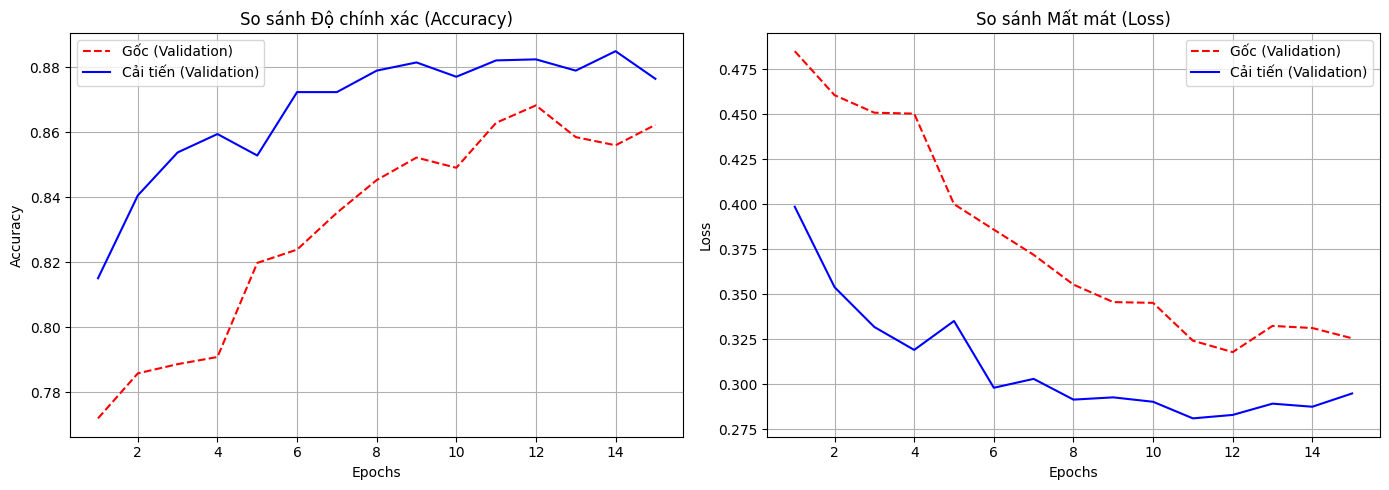

In [14]:
with open("/kaggle/input/models/training_history.json", "r") as f:
    loaded_data = json.load(f)

h_base = loaded_data["base"]
h_impr = loaded_data["improved"]

plot_comparison(h_base, h_impr)

### Ma trận nhầm lẫn

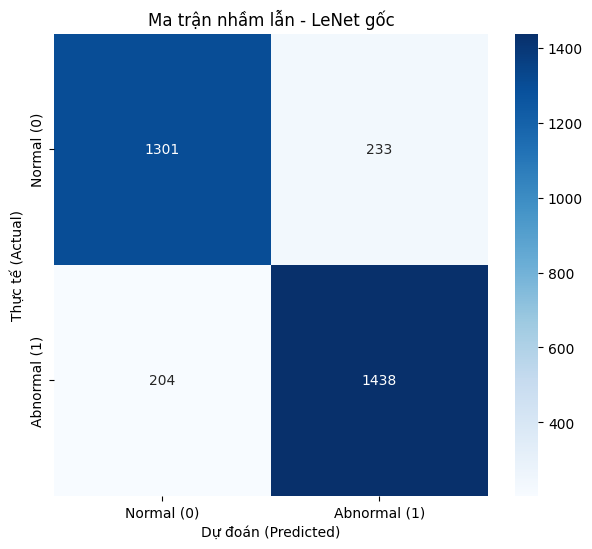

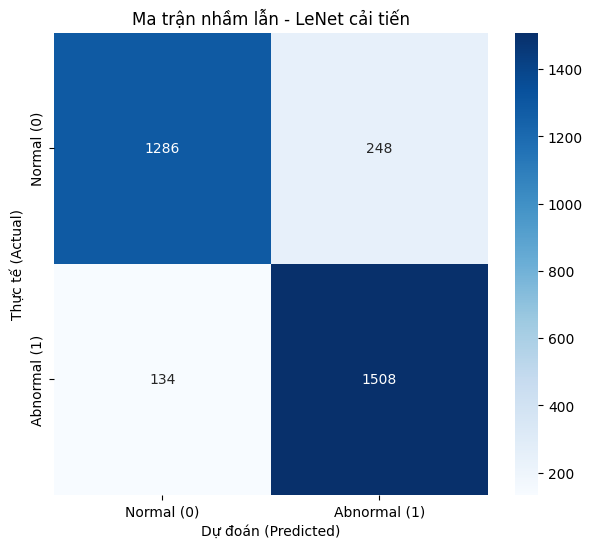

In [15]:
def plot_confusion_matrix(model, test_loader, device, name="Model"):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 6)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal (0)', 'Abnormal (1)'], 
                yticklabels=['Normal (0)', 'Abnormal (1)'])
    
    plt.xlabel('Dự đoán (Predicted)')
    plt.ylabel('Thực tế (Actual)')
    plt.title(f'Ma trận nhầm lẫn - {name}')

    plt.show() 

plot_confusion_matrix(model_base_reloaded, test_loader, device, "LeNet gốc")
plot_confusion_matrix(model_impr_reloaded, test_loader, device, "LeNet cải tiến")

### Tải ảnh thử nghiệm

In [16]:
upload_widget = widgets.FileUpload(accept='.png, .jpg, .jpeg', multiple=False)
print("Nhấn vào nút 'Upload' bên dưới để chọn ảnh X-quang từ máy tính:")
display(upload_widget)

Nhấn vào nút 'Upload' bên dưới để chọn ảnh X-quang từ máy tính:


FileUpload(value=(), accept='.png, .jpg, .jpeg', description='Upload')

In [17]:
def predict_compare(image_path, model_base, model_impr, device):
    # Chuẩn bị transform giống lúc huấn luyện
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Đọc và tiền xử lý ảnh
    img = Image.open(image_path).convert('L')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Dự đoán không tính gradient để tiết kiệm bộ nhớ
    with torch.no_grad():
        out_base = model_base(img_tensor)
        out_impr = model_impr(img_tensor)
        
        prob_base, pred_base = torch.max(torch.softmax(out_base, dim=1), 1)
        prob_impr, pred_impr = torch.max(torch.softmax(out_impr, dim=1), 1)

    labels = ["Normal (0)", "Abnormal (1)"]
    
    print(f"--- Kết quả chẩn đoán cho ảnh: {image_path} ---")
    print(f"LeNet Gốc     : {labels[pred_base.item()]} ({prob_base.item()*100:.2f}%)")
    print(f"LeNet Cải tiến: {labels[pred_impr.item()]} ({prob_impr.item()*100:.2f}%)")

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Gốc: {labels[pred_base.item()]} | Cải tiến: {labels[pred_impr.item()]}")
    plt.axis('off')
    plt.show()

Đã tải ảnh 'Viral Pneumonia-1.png' thành công. Đang tiến hành chẩn đoán...
--- Kết quả chẩn đoán cho ảnh: temp_test_img.png ---
LeNet Gốc     : Abnormal (1) (96.75%)
LeNet Cải tiến: Abnormal (1) (99.91%)


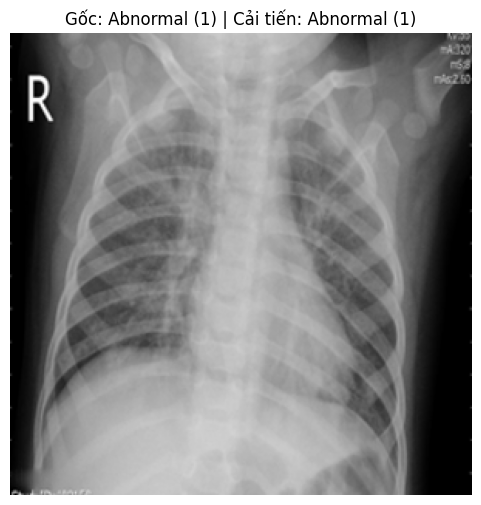

In [20]:
if len(upload_widget.value) > 0:
    uploaded_file = upload_widget.value[0]
    
    content = uploaded_file['content']

    with open("temp_test_img.png", "wb") as f:
        f.write(content)
    
    print(f"Đã tải ảnh '{uploaded_file['name']}' thành công. Đang tiến hành chẩn đoán...")

    predict_compare("temp_test_img.png", model_base_reloaded, model_impr_reloaded, device)
else:
    print("Lỗi: Bạn chưa chọn ảnh! Hãy nhấn nút 'Upload' và chọn một file trước.")